## Feature Extraction

### BERT + RISNET

In [16]:
import torch
import pandas as pd
from tqdm import tqdm
from typing import Union
from transformers import BertTokenizer
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
from PIL import Image
import io
import json
import pickle
import torch.nn as nn
from torchvision import models as vismodels
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

def split_df(df: pd.DataFrame, train_ratio: float = 0.8) -> Union[pd.DataFrame, pd.DataFrame]:
    """
    This function will split the dataframe into train and test dataframes.
    :param df: Original dataframe
    :param train_ratio: Ratio of train data
    :return: train_df, test_df
    """

    # Get unique labels
    labels = df['label'].unique()

    train_indices = []
    test_indices = []

    # Sample train_ratio of each label for training
    for label in labels:
        label_indices = df[df['label'] == label].index
        n_train = int(len(label_indices) * train_ratio)

        train_label_indices = np.random.choice(label_indices, size=n_train, replace=False)
        test_label_indices = np.setdiff1d(label_indices, train_label_indices)

        train_indices.extend(train_label_indices)
        test_indices.extend(test_label_indices)

    # Create train and test dataframes
    train_df = df.loc[train_indices]
    test_df = df.loc[test_indices]

    return train_df, test_df

def preprocess_image(image_bytes):
    
    image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
        
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image_tensor = image_transform(image)

    return image_tensor.unsqueeze(0)

def image_to_vector(image_bytes, model):
    
    model = nn.Sequential(*list(model.children())[:-1])  # Remove the last fully connected layer
    model.eval()
    model.cuda()
    
    # Convert image bytes to tensor and preprocess
    image_tensor = preprocess_image(image_bytes).cuda()
    
    with torch.no_grad():
        return model(image_tensor).squeeze().cpu()

def text_to_vector(text, tokenizer, model):
    
    model.eval()
    model.cuda()
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.cuda() for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu()


with open("../data/induced_errors.pkl","rb") as file:
    df = pickle.load(file)
    
df = df.fillna("") \
    .replace("None", "") \
    .replace("nan", "") \
    .replace("null", "")
    
train_df, test_df = split_df(df)

# replace all non negative labels with 1
train_df["label"] = train_df["label"].apply(lambda x: 1 if x >= 0 else 0)
test_df["label"] = test_df["label"].apply(lambda x: 1 if x >= 0 else 0)

# replace all -1 labels with 0
train_df["label"] = train_df["label"].apply(lambda x: 0 if x == -1 else x)
test_df["label"] = test_df["label"].apply(lambda x: 0 if x == -1 else x)

print(df.columns)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
vision_model = vismodels.resnet18(pretrained=True)

x_train, y_train, z_train = [],[],[]
x_tests, y_tests, z_tests = [],[],[]

maxid = 400000

# convert to tensors
id = 0
for index,row in tqdm(train_df.iterrows()):
    
    comb_vector = []
    comb_vector.extend(text_to_vector(row["answer"],bert_tokenizer,bert_model))
    comb_vector.extend(image_to_vector(row["cropped_image"]["bytes"],vision_model)) 
    x_train.append(comb_vector)
    y_train.append(row["label"])
    z_train.append(row["error_name"])
    if id == maxid:
        break
    id += 1
    

# convert to tensors
id = 0
for index,row in tqdm(test_df.iterrows()):
    comb_vector = []
    comb_vector.extend(text_to_vector(row["answer"],bert_tokenizer,bert_model))
    comb_vector.extend(image_to_vector(row["cropped_image"]["bytes"],vision_model)) 
    x_tests.append(comb_vector)
    y_tests.append(row["label"])
    z_tests.append(row["error_name"])
    if id == maxid:
        break
    id += 1

Index(['answer', 'label', 'cropped_image', 'old_text', 'error_name'], dtype='object')


20697it [07:37, 45.26it/s]
5177it [01:58, 43.60it/s]


In [17]:
X_train = np.array([[float(x.item()) for x in tensor] for tensor in x_train])
X_test = np.array([[float(x.item()) for x in tensor] for tensor in x_tests])

In [18]:
X_train[0], y_tests[0]

(array([-0.41914922, -0.48657697, -0.08947618, ...,  0.49273112,
         1.29910445,  0.87706465]),
 1)

### CLIP + OHV

In [159]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import io

import warnings
warnings.filterwarnings("ignore")

def split_df(df: pd.DataFrame, train_ratio: float = 0.8) -> Union[pd.DataFrame, pd.DataFrame]:
    """
    This function will split the dataframe into train and test dataframes.
    :param df: Original dataframe
    :param train_ratio: Ratio of train data
    :return: train_df, test_df
    """

    # Get unique labels
    labels = df['label'].unique()

    train_indices = []
    test_indices = []

    # Sample train_ratio of each label for training
    for label in labels:
        label_indices = df[df['label'] == label].index
        n_train = int(len(label_indices) * train_ratio)

        train_label_indices = np.random.choice(label_indices, size=n_train, replace=False)
        test_label_indices = np.setdiff1d(label_indices, train_label_indices)

        train_indices.extend(train_label_indices)
        test_indices.extend(test_label_indices)

    # Create train and test dataframes
    train_df = df.loc[train_indices]
    test_df = df.loc[test_indices]

    return train_df, test_df

def preprocess_image(image_bytes):
    
    image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
        
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image_tensor = image_transform(image)

    return image_tensor.unsqueeze(0)

def image_to_vector(images, clip_processor, clip_model):
    
    print("Converting Images")
    converted_images = []
    for img in images:
        converted_images.append(Image.open(io.BytesIO(img["bytes"])))
    
    processed_image = clip_processor(images=converted_images, return_tensors="pt")['pixel_values']
    
    print("Extracting Vectors")
    with torch.no_grad():
        image_features = clip_model.get_image_features(pixel_values=processed_image)
    
    return image_features.numpy()

def text_to_vector(texts):

    vectorizer = CountVectorizer(analyzer="char")
    bow_matrix = vectorizer.fit_transform(texts)

    return bow_matrix.toarray()

with open("../data/induced_errors.pkl","rb") as file:
    df = pickle.load(file)
    
df = df.fillna("") \
    .replace("None", "") \
    .replace("nan", "") \
    .replace("null", "")
    
train_df, test_df = split_df(df)

text_data = train_df["answer"].to_list() + test_df["answer"].to_list()
text_vectors = text_to_vector(text_data)
sep = len(train_df)

x_train = text_vectors[:sep]
y_train = train_df["label"].to_list()

x_test = text_vectors[sep:]
y_test = test_df["label"].to_list()

# Load pre-trained CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

print("Calculating img features for DF TEST")
img_features_test = image_to_vector(test_df["cropped_image"],clip_processor, clip_model)

print("Calculating img features for DF TRAIN")
img_features_train = image_to_vector(train_df["cropped_image"],clip_processor, clip_model)

Calculating img features for DF TEST
Converting Images
Extracting Vectors
Calculating img features for DF TRAIN
Converting Images
Extracting Vectors


In [160]:
x_train.__len__(), x_test.__len__(), y_train.__len__(), y_test.__len__()

(20697, 5177, 20697, 5177)

In [161]:
# Add the text and image features
# Add the text and image features

extended_test_x = []
for index,val in enumerate(img_features_test):
    arr1 =[]
    arr1 = list(x_test[index])
    arr1.extend(list(val))
    extended_test_x.append(arr1)
    
extended_train_x = []
for index,val in enumerate(img_features_train):
    arr1 = []
    arr1 = list(x_train[index])
    arr1.extend(list(val))
    extended_train_x.append(arr1)
    
# change Y values to 0
changed_test_y = []
for item in y_test:
    if item != -1:
        changed_test_y.append(1)
    else:
        changed_test_y.append(0)
        
changed_train_y = []
for item in y_train:
    if item != -1:
        changed_train_y.append(1)
    else:
        changed_train_y.append(0)

### BERT + CLIP

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import io
import pandas as pd
import warnings
from typing import Union
import pickle
import torch.nn as nn
from torchvision import models as vismodels
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import metrics
from tqdm import tqdm
warnings.filterwarnings("ignore")

def split_df(df: pd.DataFrame, train_ratio: float = 0.8) -> Union[pd.DataFrame, pd.DataFrame]:
    """
    This function will split the dataframe into train and test dataframes.
    :param df: Original dataframe
    :param train_ratio: Ratio of train data
    :return: train_df, test_df
    """

    # Get unique labels
    labels = df['label'].unique()

    train_indices = []
    test_indices = []

    # Sample train_ratio of each label for training
    for label in labels:
        label_indices = df[df['label'] == label].index
        n_train = int(len(label_indices) * train_ratio)

        train_label_indices = np.random.choice(label_indices, size=n_train, replace=False)
        test_label_indices = np.setdiff1d(label_indices, train_label_indices)

        train_indices.extend(train_label_indices)
        test_indices.extend(test_label_indices)

    # Create train and test dataframes
    train_df = df.loc[train_indices]
    test_df = df.loc[test_indices]

    return train_df, test_df

def preprocess_image(image_bytes):
    
    image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
        
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image_tensor = image_transform(image)

    return image_tensor.unsqueeze(0)

# def image_to_vector(images, clip_processor, clip_model):
    
#     print("Converting Images")
#     converted_images = []
#     for img in images:
#         converted_images.append(Image.open(io.BytesIO(img["bytes"])))
    
#     processed_image = clip_processor(images=converted_images, return_tensors="pt")['pixel_values']
    
#     print("Extracting Vectors")
#     with torch.no_grad():
#         image_features = clip_model.get_image_features(pixel_values=processed_image)
    
#     return image_features.numpy()

# def text_to_vector(text, tokenizer, model):
    
#     model.eval()
#     model.cuda()
    
#     inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     inputs = {k: v.cuda() for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = model(**inputs)
    
#     return outputs.last_hidden_state.mean(dim=1).squeeze().cpu()


def image_to_vector(images, clip_processor, clip_model, batch_size=32):
    clip_model.eval()
    clip_model.cuda()

    class ImageDataset(Dataset):
        def __init__(self, images, clip_processor):
            self.images = images
            self.clip_processor = clip_processor

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img = Image.open(io.BytesIO(self.images[idx])).convert('RGB')
            return self.clip_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0)
        
    dataset = ImageDataset(images, clip_processor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    image_features = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing image batches"):
            batch = batch.cuda()
            features = clip_model.get_image_features(pixel_values=batch)
            image_features.append(features.cpu().numpy())

    return np.concatenate(image_features)

def text_to_vector(texts, tokenizer, model, batch_size=32):
    model.eval()
    model.cuda()

    class TextDataset(Dataset):
        def __init__(self, texts, tokenizer):
            self.texts = texts
            self.tokenizer = tokenizer

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            return self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=512, return_tensors="pt")

    dataset = TextDataset(texts, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    vectors = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing batches"):
            inputs = {k: v.squeeze(1).cuda() for k, v in batch.items()}
            outputs = model(**inputs)
            batch_vectors = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            vectors.append(batch_vectors)

    return np.concatenate(vectors)

with open("../data/induced_errors_v1.pkl","rb") as file:
    df = pickle.load(file)
    
df = df.fillna("") \
    .replace("None", "") \
    .replace("nan", "") \
    .replace("null", "")
    
train_df, test_df = split_df(df)

print(df.columns)
df["label"].value_counts()

Index(['answer', 'label', 'cropped_image', 'old_text', 'error_name'], dtype='object')


label
-1    12854
 5     2500
 3     2500
 4     2490
 0     2403
 6     1656
 2     1315
 1      156
Name: count, dtype: int64

In [ ]:

# BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Load pre-trained CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# print("Calculating text features for DF TEST and TRAIN")
# text_vectors = train_df["answer"].to_list() + test_df["answer"].to_list()
# text_vectors = [text_to_vector(item, bert_tokenizer, bert_model) for item in tqdm(text_vectors)]
# text_vectors = np.array([[float(x.item()) for x in tensor] for tensor in text_vectors])
print("Calculating text features for DF TEST and TRAIN")

y_train = train_df["label"].to_list()
y_test = test_df["label"].to_list()

text_vectors = train_df["answer"].to_list() + test_df["answer"].to_list()
text_vectors = text_to_vector(text_vectors, bert_tokenizer, bert_model)

sep = len(train_df)

x_train = text_vectors[:sep]
x_test = text_vectors[sep:]

# print("Calculating img features for DF TEST")
# img_features_test = image_to_vector(test_df["cropped_image"],clip_processor, clip_model)

# print("Calculating img features for DF TRAIN")
# img_features_train = image_to_vector(train_df["cropped_image"],clip_processor, clip_model)
print("Calculating img features for DF TEST")

test_images = [img["bytes"]for img in test_df["cropped_image"]]
train_images = [img["bytes"]for img in train_df["cropped_image"]]

img_features_test = image_to_vector(test_images, clip_processor, clip_model)
print("Calculating img features for DF TRAIN")
img_features_train = image_to_vector(train_images, clip_processor, clip_model)

In [2]:
x_train.__len__(), x_test.__len__(), y_train.__len__(), y_test.__len__()

(20697, 5177, 20697, 5177)

In [3]:
# Add the text and image features
# Add the text and image features

extended_test_x = []
for index,val in enumerate(img_features_test):
    arr1 =[]
    arr1 = list(x_test[index])
    #arr1.extend(list(val))
    extended_test_x.append(arr1)
    
extended_train_x = []
for index,val in enumerate(img_features_train):
    arr1 = []
    arr1 = list(x_train[index])
    #arr1.extend(list(val))
    extended_train_x.append(arr1)
    
# change Y values to 0
changed_test_y = []
for item in y_test:
    if item != -1:
        changed_test_y.append(1)
    else:
        changed_test_y.append(0)
        
changed_train_y = []
for item in y_train:
    if item != -1:
        changed_train_y.append(1)
    else:
        changed_train_y.append(0)

changed_test_y = y_test
changed_train_y = y_train

In [4]:
extended_train_x.__len__(), changed_train_y.__len__(), extended_test_x.__len__(), changed_test_y.__len__()

(20697, 20697, 5177, 5177)

## OCR

In [5]:
from PIL import Image
import pytesseract
from io import BytesIO
import pickle
import pandas as pd
import easyocr
import warnings
warnings.filterwarnings("ignore")

def extract_text_from_image_bytes_1(image_bytes):
    
    # Create a BytesIO object
    image_data = BytesIO(image_bytes)
    
    # Open the image using PIL
    image = Image.open(image_data)
    
    # Use pytesseract to extract text
    text = pytesseract.image_to_string(image)
    
    return text

def extract_text_from_image_bytes_2(image_bytes):


    # Initialize the EasyOCR reader
    reader = easyocr.Reader(['en'])
    
    # Perform OCR on the image
    result = reader.readtext(image_bytes)

    # Extract the text
    text = ' '.join([res[1] for res in result])

    return text
    
with open("../data/induced_errors.pkl","rb") as file:
    df = pickle.load(file)

ind=0
for index, row in df.iterrows():
    
    print(row["old_text"])
    print(row["answer"])
    print(extract_text_from_image_bytes_1(row["cropped_image"]["bytes"]))
    print(extract_text_from_image_bytes_2(row["cropped_image"]["bytes"]))

    if ind==2:
        break
    ind += 1

$ 2,574,365
$ 2 574,365
y

82.574.365
Anyway the Parsifal affair was far
Anyway the Parsial affair was far
Any way {ho Farsi al alfosy WAS {av

Uay 4hua Parsial afav UIq $ Jat In4
013684
013864

013684


## LR

In [61]:
extended_train_x.__len__(), extended_train_x[0].__len__(), extended_test_x.__len__(), extended_test_x[0].__len__()

(124643, 768, 31165, 768)

In [62]:
print("Fitting Logistic Regression")
lr_model = LogisticRegression(multi_class='ovr', max_iter=3000)
lr_model.fit(extended_train_x, changed_train_y)

lr_accuracy = lr_model.score(extended_test_x, changed_test_y)
pred = lr_model.predict(extended_test_x)
actu = changed_test_y

Fitting Logistic Regression


In [74]:
# print the size of the lr_model
print(lr_model.coef_.shape)

(8, 768)


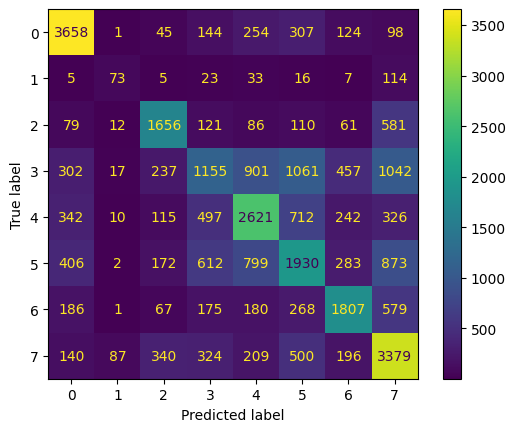

In [63]:
confusion_matrix = metrics.confusion_matrix(actu, pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7])

cm_display.plot()

In [22]:
(2200+1925) / 5177

0.7967935097546842

In [21]:
(2181+1999) / 5177

0.80741742321808

In [65]:
# if the actual label is between 0 and 6 inclusive and the predicted label is between 0 and 6 inclusive then it is correct
# if the actual label is 7 and the predicted label is 7 then it is correct
# if the actual label is 7 and the predicted label is not 7 then it is incorrect
# if the actual label is between 0 and 6 inclusive and the predicted label is 7 then it is incorrect

tp, tn, fp, fn = 0, 0, 0, 0
for i,act in enumerate(actu):
    
    if act != 7 and pred[i] != 7:
        tp += 1
    elif act == 7 and pred[i] == 7:
        tn += 1
    elif act !=7 and pred[i] == 7:
        fn += 1
    else:
        fp += 1
            
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print("True Positives:", tp/len(actu)*100)
print("True Negatives:", tn/len(actu)*100)
print("False Positives:", fp/len(actu)*100)
print("False Negatives:", fn/len(actu)*100)
print()
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy Score:", (tp + tn) / (tp + tn + fp + fn))

True Positives: 71.80170062570191
True Negatives: 10.842291031605967
False Positives: 5.762875020054548
False Negatives: 11.593133322637573

Precision: 0.9257022297604766
Recall: 0.8609849942285495
F1 Score: 0.8921715208420549
Accuracy Score: 0.8264399165730788


## LR with PCA

In [33]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Generate example data
np.random.seed(42)
X_train = np.array([[float(x.item()) for x in tensor] for tensor in x_train])
X_test = np.array([[float(x.item()) for x in tensor] for tensor in x_tests])

# Create a pipeline with StandardScaler and PCA
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

# Fit the pipeline on X_train
print("Running pipeline")
pca_pipeline.fit(X_train)

# Transform X_train
print("Fitting train data")
X_train_transformed = pca_pipeline.transform(X_train)

# Transform new unseen data
print("Fitting test data")
X_test_transformed = pca_pipeline.transform(X_test)

print(f"Original X_train shape: {X_train.shape}")
print(f"Transformed X_train shape: {X_train_transformed.shape}")
print(f"Original new data shape: {X_test.shape}")
print(f"Transformed new data shape: {X_test_transformed.shape}")

# Compare the first few dimensions of transformed train and new data
print("\nFirst few dimensions of transformed X_train:")
print(X_train_transformed[:2, :5])
print("\nFirst few dimensions of transformed new data:")
print(X_test_transformed[:2, :5])

# Check explained variance ratio
pca = pca_pipeline.named_steps['pca']
print(f"\nExplained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance ratio: {np.cumsum(pca.explained_variance_ratio_)}")

Running pipeline
Fitting train data
Fitting test data
Original X_train shape: (20697, 1280)
Transformed X_train shape: (20697, 618)
Original new data shape: (5177, 1280)
Transformed new data shape: (5177, 618)

First few dimensions of transformed X_train:
[[  4.10863381  -4.37532094  -2.64677614   9.75346918  -2.76733358]
 [-16.79362939   7.33311495   2.58697132  -1.39659988  -1.78462901]]

First few dimensions of transformed new data:
[[16.88151615  7.28364447  3.68110712 -1.3356331  -0.2391618 ]
 [ 9.84752744  6.71923013  7.2527793  -4.04851436 -0.16855912]]

Explained variance ratio: [0.10736615 0.04534306 0.03466946 0.0268376  0.02423631 0.0233031
 0.01777146 0.01678361 0.01567716 0.01394825 0.01215992 0.01150182
 0.00998284 0.00967042 0.00920153 0.00883037 0.00845453 0.0076991
 0.00753972 0.00711114 0.0069062  0.00647738 0.00631803 0.00615984
 0.00588107 0.00565825 0.00548938 0.00522968 0.00514936 0.00495138
 0.0048399  0.00466975 0.00452742 0.00438876 0.00434129 0.0042357
 0.0041

In [40]:
# Logistic Regression
print("Fitting Logistic Regression")
lr_model = LogisticRegression(multi_class='auto', max_iter=10000)
lr_model.fit(X_train, y_train)

lr_accuracy = lr_model.score(X_test, y_tests)
pred = lr_model.predict(X_test)
actu = y_tests

Fitting Logistic Regression


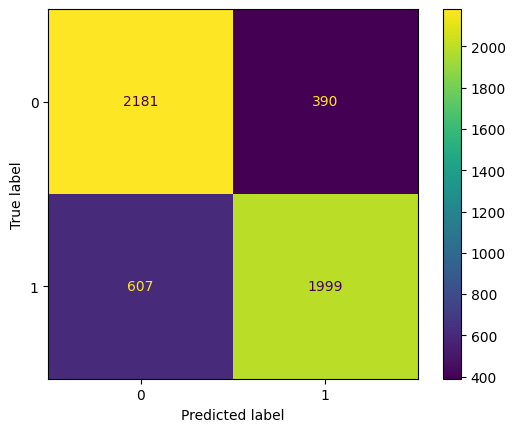

In [41]:
confusion_matrix = metrics.confusion_matrix(actu, pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()

## Random Forest and SVM

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# SVM Model
svm_model = SVC(kernel='poly', random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Evaluate SVM
print("SVM Model")
print("Accuracy:", accuracy_score(y_tests, svm_predictions))
print("Classification Report:\n", classification_report(y_tests, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_tests, svm_predictions))

# Evaluate Random Forest
print("\nRandom Forest Model")
print("Accuracy:", accuracy_score(y_tests, rf_predictions))
print("Classification Report:\n", classification_report(y_tests, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_tests, rf_predictions))

SVM Model
Accuracy: 0.8222909020668341
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83      2571
           1       0.88      0.75      0.81      2606

    accuracy                           0.82      5177
   macro avg       0.83      0.82      0.82      5177
weighted avg       0.83      0.82      0.82      5177

Confusion Matrix:
 [[2297  274]
 [ 646 1960]]

Random Forest Model
Accuracy: 0.7983388062584509
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80      2571
           1       0.82      0.76      0.79      2606

    accuracy                           0.80      5177
   macro avg       0.80      0.80      0.80      5177
weighted avg       0.80      0.80      0.80      5177

Confusion Matrix:
 [[2141  430]
 [ 614 1992]]


In [43]:
# Evaluate SVM
print("SVM Model")
print("Accuracy:", accuracy_score(y_tests, svm_predictions))
print("Classification Report:\n", classification_report(y_tests, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_tests, svm_predictions))

# Evaluate Random Forest
print("\nRandom Forest Model")
print("Accuracy:", accuracy_score(y_tests, rf_predictions))
print("Classification Report:\n", classification_report(y_tests, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_tests, rf_predictions))

SVM Model
Accuracy: 0.832721653467259
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      2571
           1       0.89      0.76      0.82      2606

    accuracy                           0.83      5177
   macro avg       0.84      0.83      0.83      5177
weighted avg       0.84      0.83      0.83      5177

Confusion Matrix:
 [[2324  247]
 [ 619 1987]]

Random Forest Model
Accuracy: 0.7407765114931427
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.80      0.75      2571
           1       0.77      0.69      0.73      2606

    accuracy                           0.74      5177
   macro avg       0.74      0.74      0.74      5177
weighted avg       0.74      0.74      0.74      5177

Confusion Matrix:
 [[2045  526]
 [ 816 1790]]


## Combo

In [43]:
_X_train = extended_train_x
_y_train = changed_train_y

_X_test = extended_test_x
_y_test = changed_test_y

In [44]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define individual models
svm = SVC(kernel='rbf', probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gbm = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
lr = LogisticRegression(penalty="l2")
mlp = MLPClassifier(hidden_layer_sizes=(100, 500), activation='relu', 
                    solver='adam', max_iter=500, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)

# Create Voting Classifier
voting_clf = VotingClassifier(estimators=[
    #('svm', svm),
    ('lr',lr),
    ('rf', rf),
    #('gbm', gbm),
    ('xgb',xgb),
    ('lgbm',lgbm),
    ('mlp',mlp)
], voting='soft')  # 'soft' uses predicted probabilities

# Fit the model
voting_clf.fit(_X_train, _y_train)

# Predictions and evaluation
voting_predictions = voting_clf.predict(_X_test)
print("Voting Classifier Model")
print("Accuracy:", accuracy_score(_y_test, voting_predictions))
print("Classification Report:\n", classification_report(_y_test, voting_predictions))
print("Confusion Matrix:\n", confusion_matrix(_y_test, voting_predictions))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.666479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 124643, number of used features: 1280
[LightGBM] [Info] Start training from score -1.906548
[LightGBM] [Info] Start training from score -4.727420
[LightGBM] [Info] Start training from score -2.443688
[LightGBM] [Info] Start training from score -1.795948
[LightGBM] [Info] Start training from score -1.857298
[LightGBM] [Info] Start training from score -1.814586
[LightGBM] [Info] Start training from score -2.256819
[LightGBM] [Info] Start training from score -1.795368
Voting Classifier Model
Accuracy: 0.5452270174875662
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      4631
           1       0.09      0.08      0.08       276
           2       0.70      0.66 

In [58]:
tp, tn, fp, fn = 0, 0, 0, 0
for i,act in enumerate(_y_test):
    
    if act != 7 and voting_predictions[i] != 7:
        tp += 1
    elif act == 7 and voting_predictions[i] == 7:
        tn += 1
    elif act !=7 and voting_predictions[i] == 7:
        fn += 1
    else:
        fp += 1
            
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print("True Positives:", tp/len(_y_test)*100)
print("True Negatives:", tn/len(_y_test)*100)
print("False Positives:", fp/len(_y_test)*100)
print("False Negatives:", fn/len(_y_test)*100)
print()
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy Score:", (tp + tn) / (tp + tn + fp + fn))

True Positives: 72.84774586876304
True Negatives: 9.391946093373978
False Positives: 7.213219958286539
False Negatives: 10.547088079576449

Precision: 0.9099034106849425
Recall: 0.8735282801077338
F1 Score: 0.8913448891855285
Accuracy Score: 0.8223969196213702


## XGBOOST

In [60]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)
print("XGBoost Model")
print("Accuracy:", accuracy_score(y_tests, xgb_predictions))
print("Classification Report:\n", classification_report(y_tests, xgb_predictions))

# LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
lgbm_predictions = lgbm.predict(X_test)
print("\nLightGBM Model")
print("Accuracy:", accuracy_score(y_tests, lgbm_predictions))
print("Classification Report:\n", classification_report(y_tests, lgbm_predictions))

# # CatBoost
# cat = CatBoostClassifier(verbose=0, random_state=42)
# cat.fit(X_train, y_train)
# cat_predictions = cat.predict(X_test)
# print("\nCatBoost Model")
# print("Accuracy:", accuracy_score(y_tests, cat_predictions))
# print("Classification Report:\n", classification_report(y_tests, cat_predictions))

XGBoost Model
Accuracy: 0.8012362372030133
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.81      2571
           1       0.82      0.77      0.80      2606

    accuracy                           0.80      5177
   macro avg       0.80      0.80      0.80      5177
weighted avg       0.80      0.80      0.80      5177

[LightGBM] [Info] Number of positive: 10414, number of negative: 10283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.459289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 20697, number of used features: 1280
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503165 -> initscore=0.012659
[LightGBM] [Info] Start training from score 0.012659

LightGBM Model
Accuracy: 0.8035541819586633
Classification Report:
               precision    recall  f1-sco

## NN

In [53]:
from sklearn.neural_network import MLPClassifier

# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', 
                    solver='adam', max_iter=500, random_state=42)

# Fit the model
mlp.fit(X_train, y_train)

# Predictions and evaluation
mlp_predictions = mlp.predict(X_test)
print("MLP Neural Network Model")
print("Accuracy:", accuracy_score(y_tests, mlp_predictions))
print("Classification Report:\n", classification_report(y_tests, mlp_predictions))


MLP Neural Network Model
Accuracy: 0.8108943403515549
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      2571
           1       0.85      0.76      0.80      2606

    accuracy                           0.81      5177
   macro avg       0.81      0.81      0.81      5177
weighted avg       0.81      0.81      0.81      5177



## Complex NN

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import tensorflow as tf

# Define a deep neural network
model = Sequential()

# Input layer
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden layers
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
X = X_train.tolist()
X = tf.constant(X, dtype=tf.float32)
Y = tf.constant(y_train)

model.fit(X,Y, epochs=100, batch_size=32)

# Evaluate the model
X = X_test.tolist()
X = tf.constant(X,dtype=tf.float32)
Y = tf.constant(y_tests)
_, accuracy = model.evaluate(X, Y)
print(f"Deep NN Accuracy: {accuracy * 100:.2f}%")

Epoch 1/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6598 - loss: 0.6544
Epoch 2/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7588 - loss: 0.4989
Epoch 3/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7933 - loss: 0.4543
Epoch 4/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7943 - loss: 0.4531
Epoch 5/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7971 - loss: 0.4428
Epoch 6/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8050 - loss: 0.4307
Epoch 7/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8074 - loss: 0.4273
Epoch 8/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8076 - loss: 0.4286
Epoch 9/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8149 - loss: 0.4216
Epoch 10/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8180 - loss: 0.4133
Epoch 11/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8256 - loss: 0.3991
Epoch 12/100
647/647 ━━━━━━━━━━━━━━━━━━━━

## Transformer

In [20]:
extended_train_x.__len__(), extended_train_x[0].__len__(), extended_test_x.__len__(), extended_test_x[0].__len__()

In [21]:
# in the train and test df, change the label value to 0 if it is -1 and 1 if it is not -1
train_df["label"] = train_df["label"].apply(lambda x: 0 if x == -1 else 1)
test_df["label"] = test_df["label"].apply(lambda x: 0 if x == -1 else 1)

train_df.columns

Index(['answer', 'label', 'cropped_image', 'old_text', 'error_name'], dtype='object')

In [22]:
train_df.columns

Index(['answer', 'label', 'cropped_image', 'old_text', 'error_name'], dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset
import torch

# Step 1: Load and Preprocess the Data
class CustomDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# # Assuming train_df and test_df have columns 'text' and 'label'
# train_df = pd.DataFrame({
#     'text': ['I love this movie', 'I hate this movie', 'It was okay'],
#     'label': [1, 0, 1]
# })
# test_df = pd.DataFrame({
#     'text': ['Best movie ever', 'Worst movie ever', 'Meh', 'I love it'],
#     'label': [1, 0, 1, 1]
# })

# Step 2: Tokenization and Encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_df['answer']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['answer']), truncation=True, padding=True)

train_dataset = CustomDataset(train_encodings, train_df['label'].tolist())
test_dataset = CustomDataset(test_encodings, test_df['label'].tolist())

# Step 3: Load the Pre-trained BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()


In [ ]:
# Step 6: Evaluate the Model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# # Step 7: Save the Model
# trainer.save_model("./finetuned_bert_model")
# tokenizer.save_pretrained("./finetuned_bert_model")

## LSTM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# Train the model
# X = x_train
# X = tf.constant(X, dtype=tf.float32)
# Y = tf.constant(y_train)
X,Y = x_train, y_train
# create and fit the LSTM network
look_back = 1
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=1, verbose=2)

In [ ]:
# Predictions and evaluation
preds = model.predict(x_tests)
print("MLP Neural Network Model")
print("Accuracy:", accuracy_score(y_tests, preds))
print("Classification Report:\n", classification_report(y_tests, preds))